In [1]:
"""
This Notebook closely follows the guide presented by Tensorflow here:
https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial
"""

'\nThis Notebook closely follows the guide presented by Tensorflow here:\nhttps://www.tensorflow.org/agents/tutorials/1_dqn_tutorial\n'

In [2]:
""" Imports: """
# Tensorflow Stuff:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.networks import categorical_q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.policies.epsilon_greedy_policy import EpsilonGreedyPolicy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.metrics import py_metrics
from tf_agents.drivers import dynamic_step_driver

import imageio
import IPython
import time
import matplotlib.pyplot as plt

In [3]:
# BM stuff:
from BMEnvironment import BMEnv
from templates.Seesaw_Template import Seesaw
from templates.Tower_Template import Tower
from templates.Blank_Template import Blank
from templates.Roof_Template import Roof
from templates.Shield_Template import Shield

from templates.PureAvoidance_Template import PureAvoidance
from observations.DoubleRaycastObservation import DoubleRayCastObservation
from rewards.NewHeightReward import NewHeightReward

In [4]:
def create_policy_eval_video(policy, env: tf_py_environment.TFPyEnvironment, py_env: BMEnv, filename, num_episodes=1, fps=60, render_obs=False):
  """ Creates a video where actions are mapped out according to the given policy """

  mode = ''
  if render_obs: 
    mode='render_observation'
  else:
    mode='render_normal'

  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = env.reset()
      video.append_data(py_env.render(mode=mode))                
      while not time_step.is_last():
        action_step = policy.action(time_step)              
        time_step = env.step(action_step)            
        video.append_data(py_env.render(mode=mode))          

In [5]:
""" Hyper-parameters """

num_iterations = 1000

initial_collect_steps = 2000

collect_steps_per_iteration = 5
replay_buffer_max_length = 40000

batch_size = 512
learning_rate = 1e-3
gamma = 0.999
start_epsilon = 0.2
exp_epsilon_decay_base = 0.99
grad_clip = 10
target_update_period = 1

fc_layer_params = (64, 64,)
num_atoms = 51  # @param {type:"integer"}
min_q_value = -10  # @param {type:"integer"}
max_q_value = 10  # @param {type:"integer"}
n_step_update = 1  # @param {type:"integer"}


num_eval_episodes = 3
eval_interval = 50
log_interval = 25

In [6]:
""" Create Environments: """    

# Choose reward function:
reward_fn = NewHeightReward()

# Choose observation function:
observation_fn = DoubleRayCastObservation()

# Choose variant ranges:
variant_range_train = (0.0, 1.0)
variant_range_test = (0.2, 0.4)

# Generic Environment:
env = BMEnv(    template=Roof(),
                variantRange=(0.0, 1.0), 
                reward_fn=reward_fn,            
                observation_fn=observation_fn  )

# Training Environment:
train_py_env = BMEnv(   template=Roof(), 
                        variantRange=variant_range_train, 
                        reward_fn=reward_fn,
                        observation_fn=observation_fn  )                        

# Evaluation Environment:
eval_py_env = BMEnv(    template=Roof(), 
                        variantRange=variant_range_test, 
                        reward_fn=reward_fn,
                        observation_fn=observation_fn  )      

# Convert to TF environments:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)                  
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)


In [7]:
""" Create Agent Q-Net: """

# Action Specification:
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1


categorical_q_net = categorical_q_network.CategoricalQNetwork(  train_env.observation_spec(), 
                                                                action_tensor_spec,
                                                                num_atoms=num_atoms,
                                                                fc_layer_params=fc_layer_params )

In [8]:
""" Create Agent: """
# Agent learning optimizer:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Counter:
train_step_counter = tf.Variable(0)


# Agent:
agent = categorical_dqn_agent.CategoricalDqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    min_q_value=min_q_value,
    max_q_value=max_q_value,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
    
agent.initialize()

In [9]:
def compute_avg_return(environment, policy, num_episodes=10):
    """
    The standard metric for evaluating a policy in an environment
    """
    total_return = 0.0
    iterations = 0
    for _ in range(num_episodes):

        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
            iterations += 1
        total_return += episode_return
        
    avg_return = total_return / iterations
    return avg_return.numpy()[0]

In [10]:
""" Replay Buffer """

table_name = 'uniform_table'
collect_data_spec = tensor_spec.from_spec(agent.collect_data_spec)

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer( data_spec=collect_data_spec,
                                                                batch_size=train_env.batch_size,
                                                                max_length=replay_buffer_max_length )

In [11]:
""" Drivers: """
metric = tf_metrics.AverageReturnMetric()

observers = [metric, replay_buffer.add_batch]

random_policy = random_tf_policy.RandomTFPolicy(    action_spec=agent.action_spec,
                                                    time_step_spec=train_env.time_step_spec()   )

dynamic_step_driver.DynamicStepDriver(  env=train_env, 
                                        policy=random_policy,
                                        observers=observers,
                                        num_steps=initial_collect_steps).run(time_step=train_env.reset())

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

iterator = iter(dataset)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [12]:
""" Initialise collect driver: """

agent.train = common.function(agent.train)

agent.train_step_counter.assign(0)

avg_return = compute_avg_return(train_env, agent.policy, num_eval_episodes)
returns = [avg_return]

time_step = train_env.reset()

collect_driver = dynamic_step_driver.DynamicStepDriver( env=train_env,
                                                        observers=observers,
                                                        policy=agent.collect_policy,                                                        
                                                        num_steps=collect_steps_per_iteration   )   

total_iterations = 0


In [13]:
""" Train Agent: """

starttime = time.time()

iteration = 0

for _ in range(num_iterations):

    iteration += 1    

    epsilon = start_epsilon * pow(exp_epsilon_decay_base, iteration)    
    
    agent._epsilon_greedy = epsilon

    time_step = collect_driver.run()

    experience, _ = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()
    total_iterations += 1

    if step % log_interval == 0:
        print('iteration = {0}: loss = {1}'.format(step, train_loss))
    
    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)        

timetaken = time.time() - starttime
print("Time taken: " + str(timetaken))


iteration = 25: loss = 3.9133472442626953
iteration = 50: loss = 3.626121997833252
step = 50: Average Return = -4.046448230743408
iteration = 75: loss = 1.6384458541870117
iteration = 100: loss = 2.778411388397217
step = 100: Average Return = -4.054562091827393
iteration = 125: loss = 1.4371293783187866
iteration = 150: loss = 2.210513114929199
step = 150: Average Return = -4.066545009613037
iteration = 175: loss = 1.6906262636184692
iteration = 200: loss = 2.1374478340148926
step = 200: Average Return = -3.6885721683502197
iteration = 225: loss = 1.6274797916412354
iteration = 250: loss = 2.070568561553955
step = 250: Average Return = 0.2752271592617035
iteration = 275: loss = 1.97330641746521
iteration = 300: loss = 1.8974545001983643
step = 300: Average Return = 0.2700515687465668
iteration = 325: loss = 2.3111493587493896
iteration = 350: loss = 1.8496752977371216
step = 350: Average Return = 0.273933082818985
iteration = 375: loss = 1.9747661352157593
iteration = 400: loss = 1.856

Text(0.5, 0, 'Iterations')

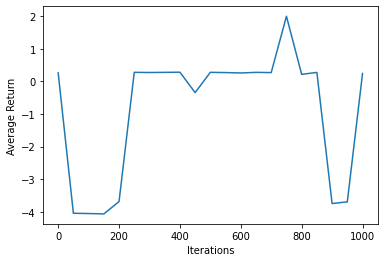

In [14]:
iterations = range(0, total_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

In [15]:
create_policy_eval_video(agent.collect_policy, eval_env, eval_py_env, "../training_videos/CDQNRoof-29-05-2022-1000iterations", 3, render_obs=False)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (800, 600) to (800, 608) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
